In [1]:
using ForwardDiff
using PyPlot
using NLopt
using Ipopt
using JuMP
using FixedSizeArrays
using ProfileView
using GeometryTypes
using LCMGL
import ForwardDiff: value

In [2]:
import SoftRobots

    +(MultiPoly.MPoly...) at /Users/rdeits/.julia/v0.4/MultiPoly/src/mpolyarithmetic.jl:2
is ambiguous with: 
    +(Lazy.List...) at /Users/rdeits/.julia/v0.4/Lazy/src/Lazy.jl:24.
To fix, define 
    +()
before the new definition.
INFO: Recompiling stale cache file /Users/rdeits/.julia/lib/v0.4/SpatialFields.ji for module SpatialFields.


In [44]:
reload("SpatialFields")
reload("SoftRobots")

INFO: Recompiling stale cache file /Users/rdeits/.julia/lib/v0.4/SpatialFields.ji for module SpatialFields.


In [45]:
robot, state = SoftRobots.tetrahedron()
world = SoftRobots.World3D()
SoftRobots.update_barrier!(robot, state)
push!(world.objects, robot)
world_state = Dict(robot => state)

Dict{SoftRobots.SoftRobot{Int64,0},SoftRobots.SoftRobotState{Float64}} with 1 entry:
  SoftRobots.SoftRobot{In… => SoftRobots.SoftRobotState{Float64}(4-elementArray…

In [46]:
function potential_energy{T}(robot, state::SoftRobots.SoftRobotState{T})
    energy = zero(T)
    for edge in robot.edges
        energy += 0.5 * edge.stiffness * 
         (norm(state.positions[edge.parent] - state.positions[edge.child]) - 
          edge.rest_length)^2
    end
    energy
end

Base.convert{T}(::Type{SoftRobots.SoftRobotState{T}}, x::Vector{T}) = SoftRobots.SoftRobotState(SoftRobots.Point{3, T}[x[i:i+2]
    for i in 1:3:(3*length(robot.nodes)-2)],
    [SoftRobots.Point{3, T}(0) for i in 1:length(robot.nodes)])

potential_energy{T}(robot, x::Vector{T}) = potential_energy(robot, convert(SoftRobots.SoftRobotState{T}, x))


draw{T}(robot, x::Vector{T}) = SoftRobots.draw(robot, convert(SoftRobots.SoftRobotState{T}, x))

value(x::Real) = x

value (generic function with 5 methods)

\begin{align}
f(x) \approx f(x_0) + \nabla f(x) |_{x_0} (x - x_0) + \frac{1}{2} (x - x_0)^\top H(x) |_{x_0} (x - x_0)
\end{align}

\begin{align}
f(x) \approx f(x_0) + \nabla f(x) |_{x_0} (x - x_0) + \frac{1}{2} x^\top H(x)|_{x_0} x - x^\top H(x)|_{x_0} x_0 + \frac{1}{2} x_0^\top H(x)|_{x_0} x_0
\end{align}

$$
\nabla f(x) \approx \nabla f(x)|_{x_0} + (x - x_0)^\top H(x)|_{x_0}
$$

$$
\nabla f(x) = 0 \implies (x - x_0)^\top H(x)|_{x_0} = -\nabla f(x)|_{x_0}
$$

$$
x - x_0 = -H^{-1} \nabla f(x)|_{x_0}
$$

$$ 
x = x_0 - H^{-1} \nabla f(x)|_{x_0}
$$

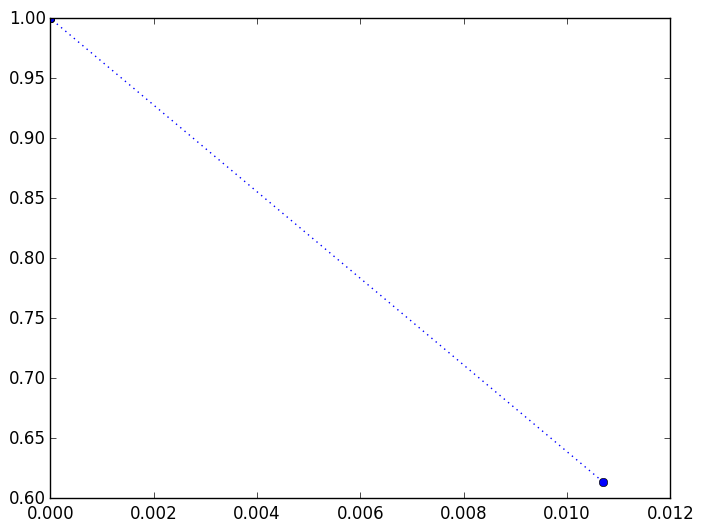

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31970bfd0>

In [6]:
function two_body_energy(x)
    0.5 * (norm(x[1] - x[2]) - 1.0)^2 + 0.5 * (x[1] - 0.0)^2
end

# .5 x1^2 - x1 x2 + .5 x2^2


f = two_body_energy
h = ForwardDiff.hessian(f)
g = ForwardDiff.gradient(f)
x = rand(2)
xs = []
energies = []
steps = 1:10
for i = steps
    push!(xs, x)
    push!(energies, f(x))
    gi = g(x)
    hi = h(x)
    x -= inv(hi) * gi
end
plot([x[1] for x in xs], [x[2] for x in xs], "bo:")

In [7]:
x0 = 0.1*rand(3 * (length(robot.nodes)));

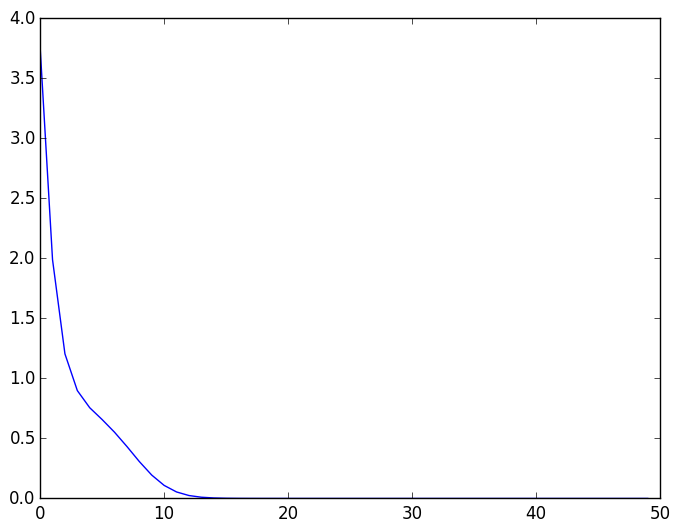

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x319b8de90>

In [8]:
g = ForwardDiff.gradient(x -> potential_energy(robot, x))
x = copy(x0)
energies = []
step = 1e-4
for i = 1:50
    gi = g(x)
    x -= step * gi
    draw(robot, x)
    push!(energies, potential_energy(robot, x))
end
plot(energies)

In [9]:
h = ForwardDiff.hessian(x -> potential_energy(robot, x))
g = ForwardDiff.gradient(x -> potential_energy(robot, x))
x = copy(x0)
energies = []
for i = 1:50
    gi = g(x)
    hi = h(x)
    x -= inv(hi) * gi
    draw(robot, x)
    push!(energies, potential_energy(robot, x))
end
plot(energies)

LoadError: LoadError: Base.LinAlg.SingularException(12)
while loading In[9], in expression starting on line 5

In [73]:
function tower()
    k = 10.
    b = 4.0
    l = 1.0
    m = 0.1
    nodes = SoftRobots.PointMass[]
    positions = SoftRobots.Point{3, Float64}[]
    
    for z = [1;2]
        x = 0
        y = 0
        push!(nodes, SoftRobots.PointMass(m))
        push!(positions, SoftRobots.Point{3, Float64}(x, y, z))
    end
    
    for z = 0:1:3
        bulge = 1 - 0.1*(z - 1.5)^2
        for x = -0.5:0.5
            for y = -0.5:0.5
                push!(nodes, SoftRobots.PointMass(m))
                push!(positions, SoftRobots.Point{3, Float64}(x*bulge, y*bulge, z))
            end
        end
    end
    for z in [-0.1; 3.1]
        for x in [-0.1; 0.1]
            for y in [-0.1; 0.1]
#     for (x,y,z) in Any[(0,0,-0.1), (0,0,3.1)]
                push!(nodes, SoftRobots.PointMass(m))
                push!(positions, SoftRobots.Point{3, Float64}(x, y, z))
            end
        end
    end
    

    num_nodes = length(nodes)
    edges = SoftRobots.DampedSpring[]
    for i = 1:num_nodes
        for j = (i+1):num_nodes
            rest_length = norm(positions[i] - positions[j])
            push!(edges, SoftRobots.DampedSpring(i, j, k, b, rest_length))
        end
    end
    faces = SoftRobots.convex_hull(positions)
    robot = SoftRobots.SoftRobot(nodes, edges, faces)
    velocities = [SoftRobots.Point{3, Float64}(0) for n in robot.nodes]
    state = SoftRobots.SoftRobotState(positions, velocities)
    robot, state
end
    
        

tower (generic function with 1 method)

In [79]:
robot, state = tower()
SoftRobots.draw(robot, state)

 41

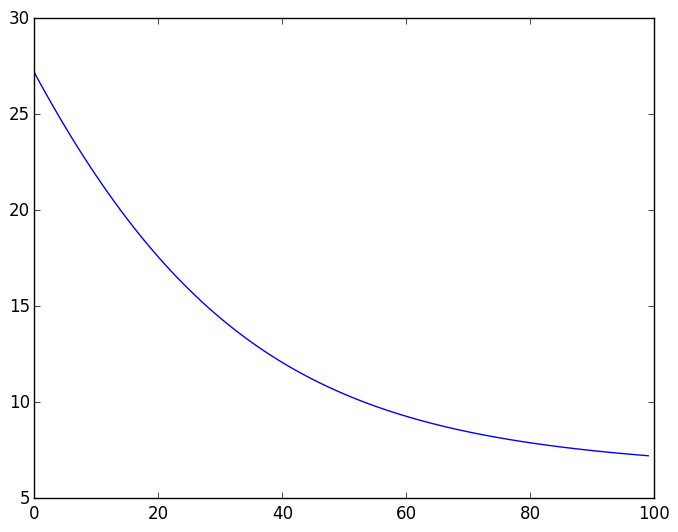

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32ca033d0>

.413967 seconds (638.82 M allocations: 14.181 GB, 5.62% gc time)


In [81]:
# point = [0.0; 0.0; 2.5]
point = [0.25; 0.0; 2.0]

function potential_energy_fixed_base{T}(robot, state::SoftRobots.SoftRobotState{T})
    energy = zero(T)
    for edge in robot.edges
        energy += 0.5 * edge.stiffness * 
         (norm(state.positions[edge.parent] - state.positions[edge.child]) - 
          edge.rest_length)^2
    end
    for i = 1:2
        energy += 0.5 * 1000 * (state.positions[i][3]-(i))^2
    end
    
    energy
end

fd_states = []

function cost{T}(x::Vector{T})
    state = convert(SoftRobots.SoftRobotState{T}, x)
    energy = potential_energy_fixed_base(robot, state)
    push!(fd_states, state)
    SoftRobots.update_barrier!(robot, state)
    v = SoftRobots.evaluate(state.barrier, point)
    if any(isnan, v)
        @show v
        @show point
    end
    if v < 0
        energy += 0.5 * 100 * v^2
    end
    energy
end

x0 = collect(destructure(state.positions))
f = cost
g = ForwardDiff.gradient(f, ForwardDiff.AllResults)
x = copy(x0)
energies = []
step = 1e-4
# Profile.clear()
@time for i = 1:100
    gi, results = g(x)
    if any(isnan, gi)
        @show gi
        error("nan in gradient")
    end
    x -= step * gi
    draw(robot, map(value, x))
    
    state = convert(SoftRobots.SoftRobotState{Float64}, map(value, x))
    mesh = HomogenousMesh(state.positions, robot.faces)

    LCMGLClient("normals") do lcmgl
        normals = decompose(GeometryTypes.Normal{3, Float64}, mesh)
        color(lcmgl, 0,0,0)
        begin_mode(lcmgl, LCMGL.LINES)
        for i = 1:length(state.positions)
            vertex(lcmgl, state.positions[i]...)
            vertex(lcmgl, (state.positions[i] + Point(normals[i]))...)
        end
        end_mode(lcmgl)
        switch_buffer(lcmgl)
    end
    push!(energies, value(results))
end
# ProfileView.view()
plot(energies)


In [77]:
x

78-element Array{Float64,1}:
  2.06042e-16
  1.43884e-16
  1.00293    
  1.71986e-15
  2.59783e-15
  1.93762    
 -0.385647   
 -0.385647   
  0.000309194
 -0.385647   
  0.385647   
  0.000309194
  0.385647   
  ⋮          
 -0.109675   
 -0.109675   
  3.09302    
 -0.109675   
  0.109675   
  3.09302    
  0.109675   
 -0.109675   
  3.09302    
  0.109675   
  0.109675   
  3.09302    